In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
import scipy.signal as sps
import fit_lag_model as flm
import itertools as it

%matplotlib inline

# set matplotlib output type
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf')

In [14]:
sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

In [15]:
# Connect to DB
zidisha_db = qdb.QueryDatabase('zidisha')

sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

sql_query_short = lambda x: zidisha_db.source_query(sql_dir, x, where_filter_col='country_name', where_filter_list=list_countries)

# Accepted borrower account creation dates
list_df_new_borrowers = sql_query_short('borrowers_w_countries.sql')
for df in list_df_new_borrowers:
    df.insert(0, 'Number of new borrowers', range(len(df)))

# Borrower first loan creation dates
list_df_first_loans = sql_query_short('first_loans_w_countries.sql')
for df in list_df_first_loans:
    df.insert(0, 'Number of first loans', range(len(df)))

# Time to funding
list_df_time_to_fund = sql_query_short('time_to_funding.sql')
    
# Time to disbursement
list_df_time_to_disbursement = sql_query_short('time_to_disbursement.sql')
    
# All loans
list_df_all_loans = sql_query_short('all_loans.sql')

# Fully funded loans
list_df_fully_funded_loans = sql_query_short('fully_funded_loans.sql')

# Load exchange rates
list_df_exchange_start = sql_query_short('exchange_rates_start.sql')

# Invited loans
list_df_invited_loans = sql_query_short('invitee_new_loans.sql')

In [16]:
weeks_per_bin = 1
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, str(weeks_per_bin)+'W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str, col_index=0: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, col_to_bin=col_index, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

df_time_to_fund = bin_short(list_df_time_to_fund, 'median')
df_time_to_disbursement = bin_short(list_df_time_to_disbursement, 'median')

df_usd_requested = bin_short(list_df_all_loans, 'sum', 0)
df_raised_fraction = bin_short(list_df_all_loans, 'median', 1)
df_usd_inflow = bin_short(list_df_all_loans, 'sum', 2)
df_usd_secured = bin_short(list_df_all_loans, 'sum', 3)
df_secured_fraction = df_usd_secured / df_usd_requested

df_usd_requested_new = bin_short(list_df_first_loans, 'sum', 2)
df_raised_fraction_new = bin_short(list_df_first_loans, 'median', 3)
df_usd_inflow_new = bin_short(list_df_first_loans, 'sum', 4)
df_usd_secured_new = bin_short(list_df_first_loans, 'sum', 5)
df_secured_fraction_new = df_usd_secured_new / df_usd_requested_new

df_usd_requested_new_frac = df_usd_requested_new / df_usd_requested
df_usd_secured_new_frac = df_usd_secured_new / df_usd_secured

df_invitee_first_loan_count = bin_short(list_df_invited_loans, 'count')
df_invitee_first_loan_frac = df_invitee_first_loan_count / df_first_loans_count

# Policies
df_loan_loss_fee_kenya = load_Zidisha.loan_loss_reserve_fee_Kenya(time_bins_center)
df_loan_loss_fee_other = load_Zidisha.loan_loss_reserve_fee_Other(time_bins_center)
df_loan_loss_fee_indonesia = load_Zidisha.loan_loss_reserve_fee_indonesia(time_bins_center)
df_loan_loss_fee_ghana = load_Zidisha.loan_loss_reserve_fee_ghana(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)
df_website_change = load_Zidisha.website_change(time_bins_center)
df_upfront_fee = load_Zidisha.upfront_fee(time_bins_center)


In [17]:
def rect_window_filter(data: np.array, window_length: int) -> np.array:
    window_length = np.round(window_length)
    if window_length:
        if window_length % 2 == 0:# even
            front_pad = window_length/2
            end_pad = window_length/2
            norm_window = np.repeat(1.0, window_length + 1)
            norm_window[0] = 0.5
            norm_window[-1] = 0.5
            norm_window /= window_length
        else:
            front_pad = (window_length - 1)/2
            end_pad = front_pad
            norm_window = np.repeat(1.0, window_length) / window_length
        data_long = np.pad(data, ((front_pad, end_pad),), mode='edge')
        # avoid fftconvolve as it distributes one input NaN to entire output
        data_filt = sps.convolve(data_long, norm_window, 'valid')
    else:
        data_filt = data.copy()
    return data_filt

def causal_rect_window_filter(data: np.array, window_length: int) -> np.array:
    window_length = np.round(window_length)
    if window_length > 0:
        front_pad = window_length - 1
        end_pad = 0
        norm_window = np.repeat(1.0, window_length) #/ window_length
        norm_window[0] = 0.5
        norm_window[-1] = 0.5
        norm_window /= np.sum(norm_window)
        data_long = np.pad(data, ((front_pad, end_pad),), mode='edge')
        # avoid fftconvolve as it distributes one input NaN to entire output
        data_filt = sps.convolve(data_long, norm_window, 'valid')
    else:
        data_filt = data.copy()
    return data_filt

def causal_hann_window_filter(data: np.array, window_length: int) -> np.array:
    window_length = np.round(window_length)
    if window_length > 0:
        front_pad = window_length
        end_pad = 1
        norm_window = sps.hann(window_length + 2) #/ window_length
        norm_window /= np.sum(norm_window)
        data_long = np.pad(data, ((front_pad, end_pad),), mode='edge')
        # avoid fftconvolve as it distributes one input NaN to entire output
        data_filt = sps.convolve(data_long, norm_window, 'valid')
    else:
        data_filt = data.copy()
    return data_filt

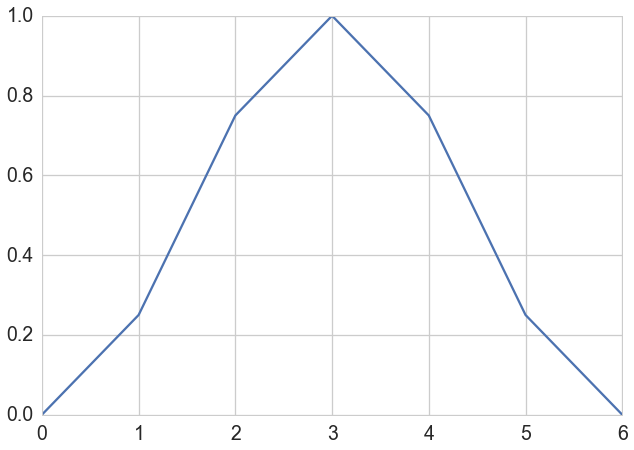

In [6]:
plt.plot(sps.hann(5+2))

In [54]:
step = np.zeros(12)
lag_step = step.copy()
step[6:] = 1
lag_step[8:] = 1
rect_step = flm.causal_rect_window_filter(step, 5)
hann_step = flm.causal_hann_window_filter(step, 5)
step_labels = ['Step', 'Lagged step', 'Moving average (MA)', 'Weighted MA']
step_arrays = [step, lag_step, rect_step, hann_step]
step_dict = {key: value for key, value in zip(step_labels, step_arrays)}
df_step = pd.DataFrame(step_dict, columns=step_labels)
step_style = ['-o', '-o', '-o', '--o']
df_step.plot(style=step_style, yticks=[0, 0.5, 1], figsize=(10, 4.5))
plt.ylim([-0.1, 1.1]);

30 30 30


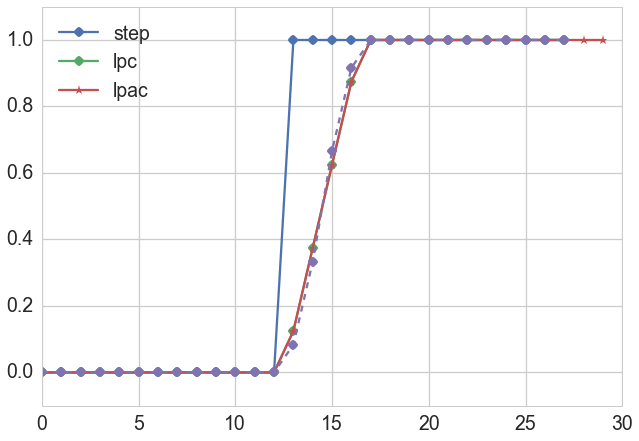

In [8]:
step = np.zeros(30)
step[15:] = 1
lpc_step = causal_rect_window_filter(step, 5)
lpac_step = rect_window_filter(step, 4)
hannc_step = causal_hann_window_filter(step, 5)
print(len(lpc_step), len(lpac_step), len(hannc_step))
lpc_step = lpc_step[2:]
step = step[2:]
hannc_step = hannc_step[2:]
plt.plot(step, '-o')
plt.plot(lpc_step, '-o')
plt.plot(lpac_step, '-*')
plt.plot(hannc_step, '--o')
plt.legend(['step', 'lpc', 'lpac'], loc=2)
plt.ylim([-0.1, 1.1]);


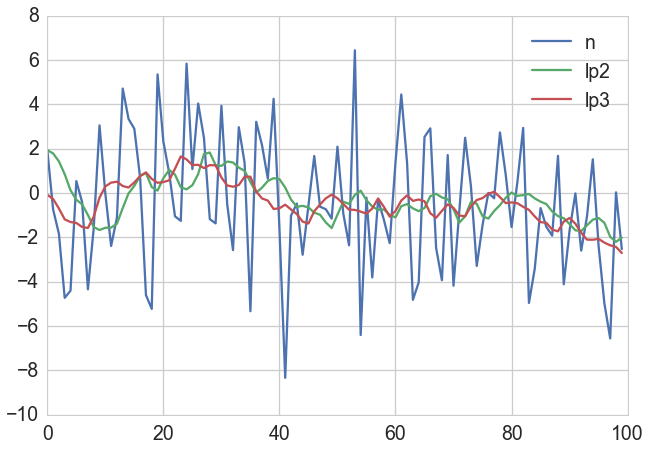

In [9]:
noise = np.random.normal(0,3,100)
lp2_noise = causal_rect_window_filter(noise, 10)
lp3_noise = rect_window_filter(noise, 10)
plt.plot(noise)
plt.plot(lp2_noise)
plt.plot(lp3_noise)
plt.legend(['n', 'lp2', 'lp3'])

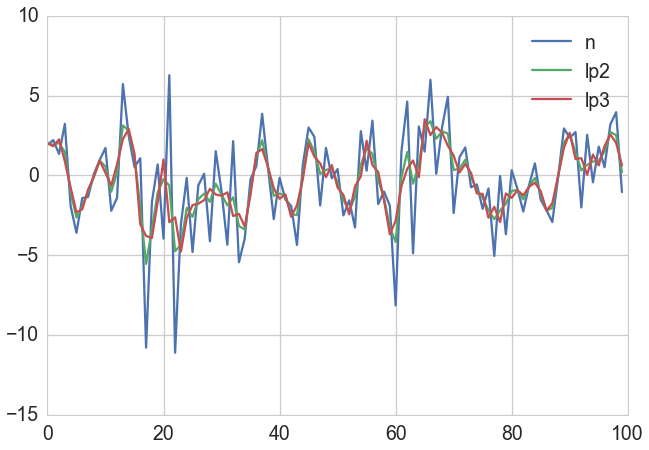

In [10]:
noise = np.random.normal(0,3,100)
lp2_noise = rect_window_filter(noise, 2)
lp3_noise = rect_window_filter(noise, 3)
plt.plot(noise)
plt.plot(lp2_noise)
plt.plot(lp3_noise)
plt.legend(['n', 'lp2', 'lp3'])

In [50]:
#Fit of Ghana, Lagged

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

transition_time = round(5.0/weeks_per_bin)
lag = 0
web_lag = 0
fund_lag = 2
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Ghana.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_ghana.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# fund rate effect after web change
#fund_rate_after = fund_rate_feature.copy()
#fund_rate_after *= web_change

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Ghana.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, upfront_fee]

lag_model_ghana = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
#lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center, data_variance=dependent_array)
lag_model_ghana.fit(start_time=start_date)
lag_model_ghana.print_summary()
df_fit = lag_model_ghana.display_fit('Ghana', y_label='First loans per week')

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Ghana', 'Model'], loc=2)

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
ghana_fit_scaled = lag_model_ghana.get_normalized_results(peak_start, peak_end)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     72.42
Date:                Sun, 04 Oct 2015   Prob (F-statistic):           2.82e-21
Time:                        22:29:37   Log-Likelihood:                -272.53
No. Observations:                  73   AIC:                             553.1
Df Residuals:                      69   BIC:                             562.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2728      1.619      3.256      0.0

In [46]:
#Fit of Indonesia, Lagged

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

transition_time = round(5.0/weeks_per_bin)
lag = 0
web_lag = 2
fund_lag = 2
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Indonesia.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_indonesia.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# fund rate effect after web change
#fund_rate_after = fund_rate_feature.copy()
#fund_rate_after *= web_change

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Indonesia.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, upfront_fee]

lag_model_indonesia = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
#lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center, data_variance=dependent_array)
lag_model_indonesia.fit(start_time=start_date)
lag_model_indonesia.print_summary()
df_fit = lag_model_indonesia.display_fit('Indonesia', y_label='First loans per week')

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Indonesia', 'Model'], loc=2)

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
indonesia_fit_scaled = lag_model_indonesia.get_normalized_results(peak_start, peak_end)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     85.91
Date:                Sun, 04 Oct 2015   Prob (F-statistic):           3.00e-23
Time:                        22:17:37   Log-Likelihood:                -216.46
No. Observations:                  73   AIC:                             440.9
Df Residuals:                      69   BIC:                             450.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.9452      0.734      2.650      0.0

In [65]:
list_transition = [3, 4, 5, 6, 7]
list_lag = [0]
list_web_lag = [0, 1, 2]
list_fund_lag = [1, 2, 3, 4]
list_filter = ['rect', 'hann']

def fit_kenya(transition_time_fund, transition_time_fee, transition_time_web, transition_time_up, lag, web_lag, fund_lag, filter_name):

    # fund rate
    fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time_fund, shift_size=fund_lag+lag, filter_type=filter_name)

    # loan loss fee
    loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time_fee, shift_size=lag, filter_type=filter_name)

    # web change
    web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time_web, shift_size=web_lag+lag, filter_type=filter_name)

    # upfront fee
    upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time_up, shift_size=lag, filter_type=filter_name)

    # output
    dependent_array = df_first_loans_count.Kenya.values

    start_date = np.datetime64('2014-04-01T00Z', 'ns')

    list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

    lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
    lag_model_kenya.fit(start_time=start_date)
    return lag_model_kenya.results.rsquared_adj

all_comb = it.product(list_transition, list_transition, list_transition, list_transition, list_lag, list_web_lag, list_fund_lag, list_filter)
comb_labels = ['Transition fund', 'Transition fee', 'Transition web', 'Transition up', 'Lag', 'Web lag', 'Fund lag', 'Filter', 'R2']
dict_comb = {label: [] for label in comb_labels}
df_comb = pd.DataFrame(dict_comb, columns=comb_labels)
for index, comb in enumerate(all_comb):
    list_comb = list(comb)
    r2 = fit_kenya(*comb)
    list_comb.append(r2)
    df_comb.loc[index] = list_comb


In [66]:
df_comb.sort(columns='R2', ascending=False)

,Transition fund,Transition fee,Transition web,Transition up,Lag,Web lag,Fund lag,Filter,R2
2166,3,6,6,3,0,0,4,rect,0.890031
2766,3,7,6,3,0,0,4,rect,0.889385
2190,3,6,6,4,0,0,4,rect,0.888015
11762,6,7,6,3,0,0,2,rect,0.887205
11162,6,6,6,3,0,0,2,rect,0.887054
14162,7,6,6,3,0,0,2,rect,0.886984
14762,7,7,6,3,0,0,2,rect,0.886776
1566,3,5,6,3,0,0,4,rect,0.886720
5166,4,6,6,3,0,0,4,rect,0.886648
2046,3,6,5,3,0,0,4,rect,0.886611


In [61]:
list_transition = [1, 2, 3, 4, 5, 6, 7, 8]
list_lag = [0, 1, 2, 3]
list_web_lag = [0, 1, 2, 3]
list_fund_lag = [0, 1, 2, 3, 4]
list_filter = ['none', 'rect', 'hann']

def fit_kenya(transition_time, lag, web_lag, fund_lag, filter_name):

    # fund rate
    fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

    # loan loss fee
    loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

    # web change
    web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

    # upfront fee
    upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

    # output
    dependent_array = df_first_loans_count.Kenya.values

    start_date = np.datetime64('2014-04-01T00Z', 'ns')

    list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

    lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
    lag_model_kenya.fit(start_time=start_date)
    return lag_model_kenya.results.rsquared_adj

all_comb = it.product(list_transition, list_lag, list_web_lag, list_fund_lag, list_filter)
comb_labels = ['Transition', 'Lag', 'Web lag', 'Fund lag', 'Filter', 'R2']
dict_comb = {label: [] for label in comb_labels}
df_comb = pd.DataFrame(dict_comb, columns=comb_labels)
for index, comb in enumerate(all_comb):
    list_comb = list(comb)
    r2 = fit_kenya(*comb)
    list_comb.append(r2)
    df_comb.loc[index] = list_comb


In [62]:
df_comb.sort(columns='R2', ascending=False)

,Transition,Lag,Web lag,Fund lag,Filter,R2
970,5,0,0,3,rect,0.875651
973,5,0,0,4,rect,0.874257
967,5,0,0,2,rect,0.874120
748,4,0,1,4,rect,0.866932
1207,6,0,0,2,rect,0.866590
1210,6,0,0,3,rect,0.864825
985,5,0,1,3,rect,0.864211
745,4,0,1,3,rect,0.864177
971,5,0,0,3,hann,0.863523
1204,6,0,0,1,rect,0.862972


In [44]:
#Fit of Kenya, Lagged

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

transition_time = round(5.0/weeks_per_bin)
lag = 0
web_lag = 0
fund_lag = 2
filter_name = 'hann'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=fund_lag+lag, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, shift_size=lag, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=web_lag+lag, filter_type=filter_name)

# fund rate effect after web change
#fund_rate_after = fund_rate_feature.copy()
#fund_rate_after *= web_change

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, shift_size=lag, filter_type=filter_name)

# invite feature
max_invite = flm.LaggedParameter(df_total_borrowers.Kenya.values * df_max_invites.max_invites.values, 'Max invites', transition_time, shift_size=lag, filter_type=filter_name)

# max loan feature
max_loan = flm.LaggedParameter(df_max_first_loan.max_loan.values, 'Max loan', transition_time, shift_size=lag, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Kenya.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
#lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center, data_variance=dependent_array)
lag_model_kenya.fit(start_time=start_date)
lag_model_kenya.print_summary()

sns.set()
sns.set_context('talk', font_scale=1.1)
sns.set_style('whitegrid')

ws_width = 10
ws_height = 1.5

df_fit = lag_model_kenya.display_fit('Kenya', y_label='First time loans per week')

df_fit.plot(figsize=(ws_width, 3*ws_height), style=['o', '-'], legend=False)
plt.ylabel('First loans per week')
plt.legend(['Kenya', 'Model'], loc=2)

df_plot = df_fund_rate[['Kenya']].plot(figsize=(ws_width, ws_height), legend=False, ylim=(0, 1.1), yticks=([0,0.5,1]), style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.legend(['Fractional fund rate'], loc=3)
df_plot.set_xticklabels([])

df_plot = df_upfront_fee.plot(figsize=(ws_width, ws_height), yticks=[0, 0.5, 1], legend=False, style=['--r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])
plt.legend(['Upfront fee'], loc=2)
df_plot.set_xticklabels([])

sns.set()
sns.set_context('talk', font_scale=1.5)
sns.set_style('whitegrid')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
kenya_fit_scaled = lag_model_kenya.get_normalized_results(peak_start, peak_end)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     107.3
Date:                Sun, 04 Oct 2015   Prob (F-statistic):           1.28e-28
Time:                        22:05:24   Log-Likelihood:                -313.84
No. Observations:                  73   AIC:                             637.7
Df Residuals:                      68   BIC:                             649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         67.4292      4.998     13.491      0.0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     126.0
Date:                Sun, 04 Oct 2015   Prob (F-statistic):           1.11e-30
Time:                        17:26:55   Log-Likelihood:                -308.72
No. Observations:                  73   AIC:                             627.4
Df Residuals:                      68   BIC:                             638.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         67.1009      4.830     13.894      0.0

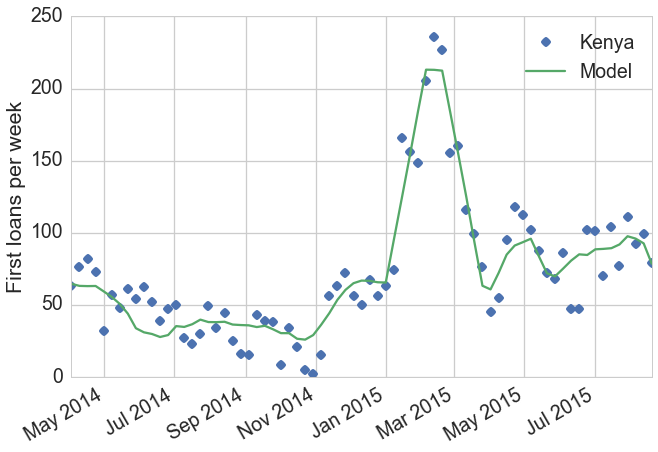

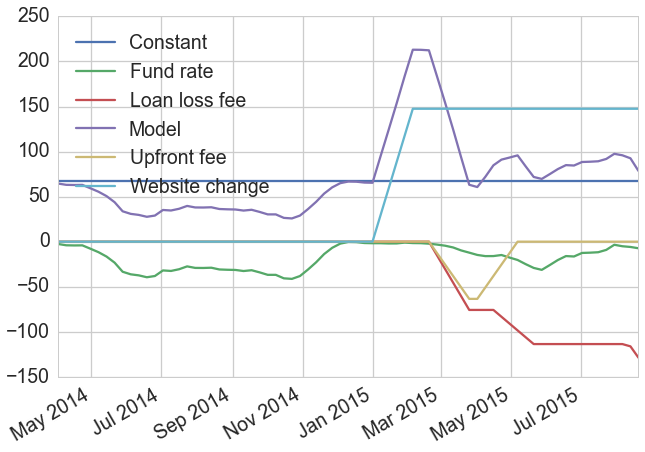

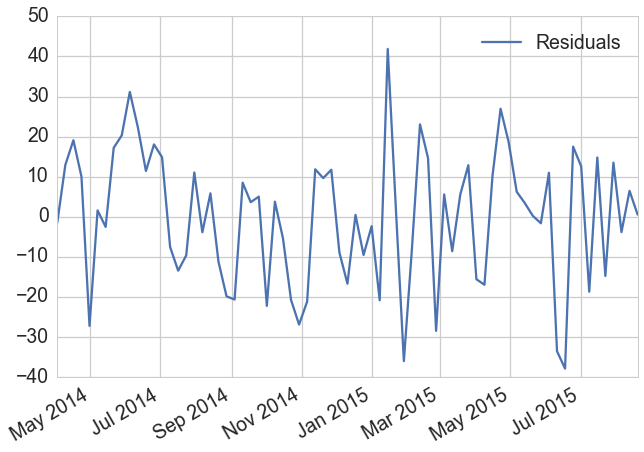

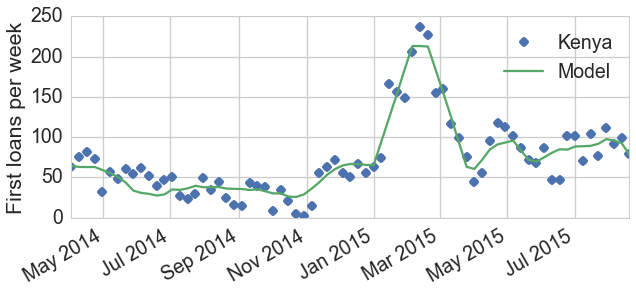

In [22]:
#Fit of Kenya, causal filter, Rect filter

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

df_kenya_fit_params = pd.DataFrame(index=time_bins_center)

transition_time = round(5.0/weeks_per_bin)
filter_name = 'rect'

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=2, filter_type=filter_name)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time, filter_type=filter_name)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time, shift_size=0, filter_type=filter_name)

# fund rate effect after web change
#fund_rate_after = fund_rate_feature.copy()
#fund_rate_after *= web_change

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time, filter_type=filter_name)

# invite feature
max_invite = flm.LaggedParameter(df_total_borrowers.Kenya.values * df_max_invites.max_invites.values, 'Max invites', transition_time, filter_type=filter_name)

# max loan feature
max_loan = flm.LaggedParameter(df_max_first_loan.max_loan.values, 'Max loan', transition_time, filter_type=filter_name)

# output
dependent_array = df_first_loans_count.Kenya.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
#lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center, data_variance=dependent_array)
lag_model_kenya.fit(start_time=start_date)
lag_model_kenya.print_summary()
df_fit = lag_model_kenya.display_fit('Kenya', y_label='First loans per week')

df_fit.plot(figsize=(10, 4), style=['o', '-'])
plt.ylabel('First loans per week')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
kenya_fit_scaled = lag_model_kenya.get_normalized_results(peak_start, peak_end)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     107.3
Date:                Sun, 04 Oct 2015   Prob (F-statistic):           1.28e-28
Time:                        17:14:50   Log-Likelihood:                -313.84
No. Observations:                  73   AIC:                             637.7
Df Residuals:                      68   BIC:                             649.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         67.4292      4.998     13.491      0.0

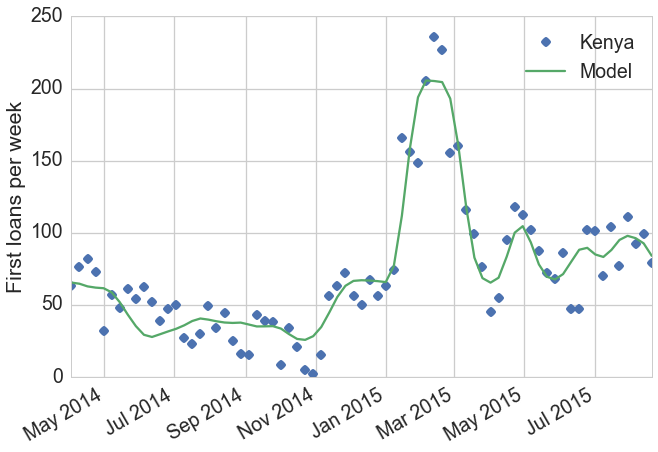

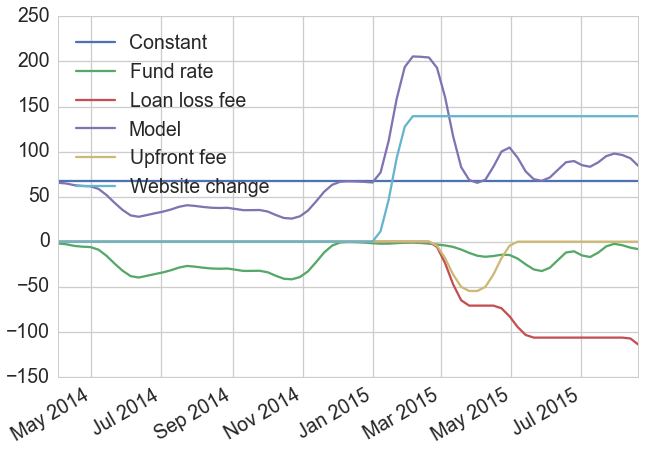

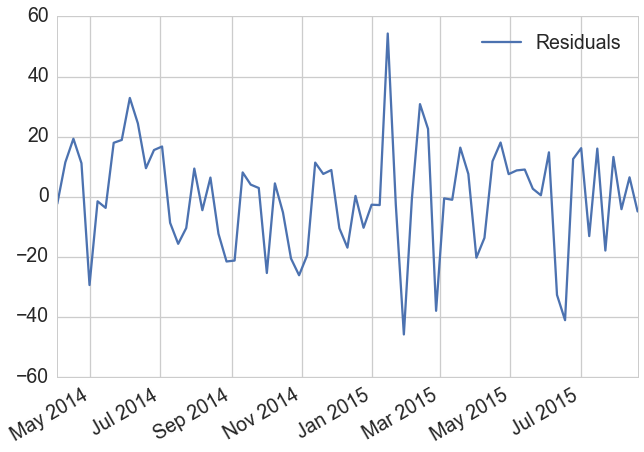

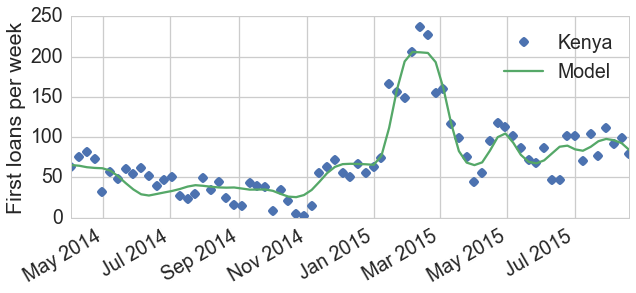

In [31]:
#Fit of Kenya, causal filter, Hann filter

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

df_kenya_fit_params = pd.DataFrame(index=time_bins_center)

transition_time = round(5.0/weeks_per_bin)

# fund rate
fund_rate = flm.LaggedParameter(df_fund_rate.Kenya.values - 1, 'Fund rate', transition_time, shift_size=2)

# loan loss fee
loan_loss_fee = flm.LaggedParameter(df_loan_loss_fee_kenya.fee_level.values/df_max_first_loan.max_loan.values, 'Loan loss fee', transition_time)

# web change
web_change = flm.LaggedParameter(df_website_change.web_change.values, 'Website change', transition_time)

# fund rate effect after web change
#fund_rate_after = fund_rate_feature.copy()
#fund_rate_after *= web_change

# upfront fee
upfront_fee = flm.LaggedParameter(df_upfront_fee.upfront_fee.values, 'Upfront fee', transition_time)

# invite feature
max_invite = flm.LaggedParameter(df_total_borrowers.Kenya.values * df_max_invites.max_invites.values, 'Max invites', transition_time)

# max loan feature
max_loan = flm.LaggedParameter(df_max_first_loan.max_loan.values, 'Max loan', transition_time)

# output
dependent_array = df_first_loans_count.Kenya.values

start_date = np.datetime64('2014-04-01T00Z', 'ns')

list_lag_params = [loan_loss_fee, web_change, fund_rate, upfront_fee]

lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center)
#lag_model_kenya = flm.LagModel(list_lag_params, dependent_array, time_bins_center, data_variance=dependent_array)
lag_model_kenya.fit(start_time=start_date)
lag_model_kenya.print_summary()
df_fit = lag_model_kenya.display_fit('Kenya', y_label='First loans per week')

df_fit.plot(figsize=(10, 4), style=['o', '-'])
plt.ylabel('First loans per week')

peak_start = np.datetime64('2015-01-01T00Z', 'ns')
peak_end = np.datetime64('2015-03-01T00Z', 'ns')
kenya_fit_scaled = lag_model_kenya.get_normalized_results(peak_start, peak_end)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     96.77
Date:                Sat, 03 Oct 2015   Prob (F-statistic):           1.53e-27
Time:                        14:03:14   Log-Likelihood:                -321.39
No. Observations:                  74   AIC:                             652.8
Df Residuals:                      69   BIC:                             664.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         64.6702      5.211     12.410      0.0

,0,1,2,3,4
0,1.000000,0.250714,-0.558892,0.815757,0.066700
1,0.250714,1.000000,-0.824925,0.287603,0.180125
2,-0.558892,-0.824925,1.000000,-0.439131,-0.348596
3,0.815757,0.287603,-0.439131,1.000000,0.072821
4,0.066700,0.180125,-0.348596,0.072821,1.000000


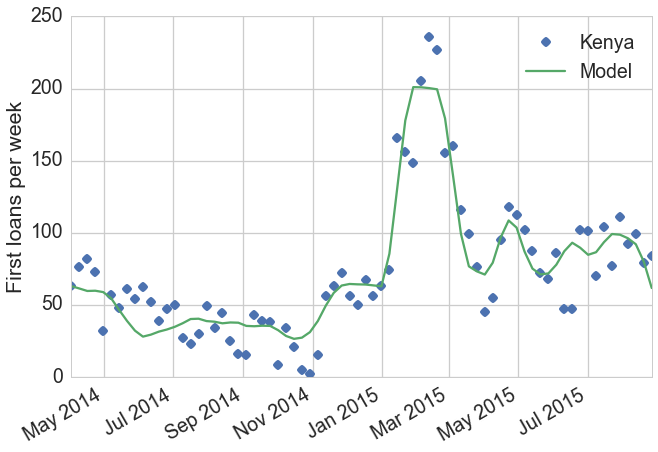

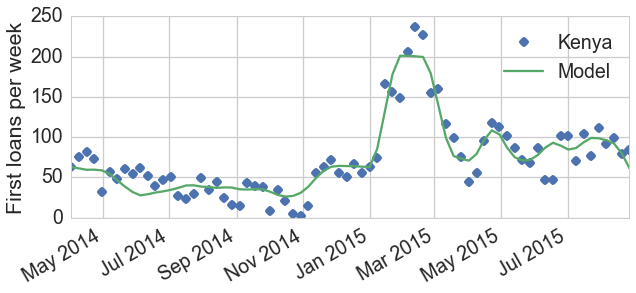

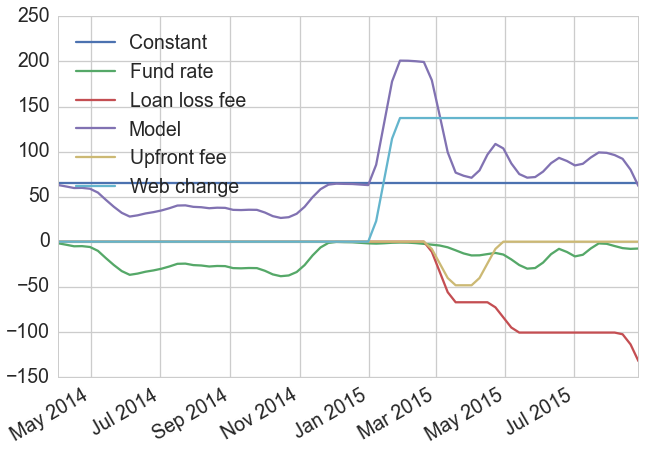

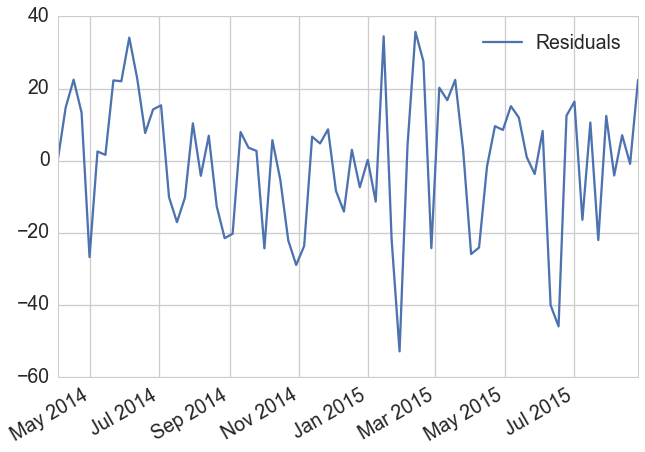

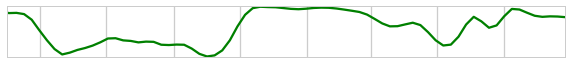

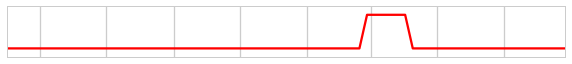

In [24]:
#Fit of Kenya, causal filter

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

df_kenya_fit_params = pd.DataFrame(index=time_bins_center)

# max lag
lag = round(4.0 / weeks_per_bin)

# fund rate
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = df_fund_rate.Kenya.values.copy() - 1
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = causal_rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
df_kenya_fit_params['Fund rate'] = fund_rate_feature
fund_rate_feature = fund_rate_feature[lag_comp:-2]
#fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]

# loan loss fee
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
'''
if lag_end:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
'''
loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values.copy()
max_loan = df_max_first_loan.max_loan.values.copy()
loan_loss_fee /= max_loan
loan_loss_fee = causal_rect_window_filter(loan_loss_fee, lag_fee*2)
loan_loss_fee = loan_loss_fee[lag_comp2:].copy()
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)

# web change
lag_comp3 = round(2.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
'''
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
'''
web_change = df_website_change.web_change.values.copy()
web_change = causal_rect_window_filter(web_change, 4)
web_change = web_change[lag_comp3:].copy()

# fund rate effect after web change
fund_rate_after_feature = fund_rate_feature.copy()
fund_rate_after_feature *= web_change

# upfront fee
lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
#upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
upfront_fee_feature = df_upfront_fee.upfront_fee.values.copy()
upfront_fee_feature = causal_rect_window_filter(upfront_fee_feature, 2*lag_upfront)
upfront_fee_feature = upfront_fee_feature[lag_comp4:].copy()


invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[2:].copy()
label_array = df_first_loans_count.Kenya.values[2:].copy()
time_axis = time_bins_center[2:].copy()


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]
fund_rate_after_feature = fund_rate_after_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

#print(len(fund_rate_feature), len(loan_loss_fee), len(web_change), len(upfront_fee_feature), len(label_array))

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['o', '-'])
plt.ylabel('First loans per week')
#plt.xlabel('Date')


stack_fig_width = 10
stack_fig_height = 1
df_fit2 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, columns=['Kenya', 'Model'],index=time_axis)
df_fit2.plot(figsize=(stack_fig_width, 4*stack_fig_height), style=['o', '-'])
plt.ylabel('First loans per week')


#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
#labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee', 'Fund rate after']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

peak_times = np.array([np.datetime64('2015-01-01T00Z', 'ns'), np.datetime64('2015-03-01T00Z', 'ns')])
peak_range = np.searchsorted(time_axis.values, peak_times)
norm_scale = 1 / np.amax(results.predict()[peak_range[0]:peak_range[1]])

kenya_nlr = label_array.copy()
#kenya_scaled = kenya_nlr.copy() * results.params[0]/results.params[2]
kenya_scaled = kenya_nlr.copy() * norm_scale
kenya_fit_scaled = results.predict() * norm_scale

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

kenya_norm_params = results.params / results.params[0]
kenya_norm_bse = results.bse / results.params[0]
print(kenya_norm_params)
print(kenya_norm_bse)

print(kenya_norm_params[2] + 2*np.sqrt(kenya_norm_bse[0]**2 + kenya_norm_bse[2]**2))

stack_fig_width = 10
stack_fig_height = 1
df_plot = df_kenya_fit_params.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
#df_fund_rate_feature = pd.DataFrame({'Fund rate': fund_rate_feature}, index=time_axis)
#df_plot = df_fund_rate_feature.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.yticks([])
df_plot.set_xticklabels([])


#df_upfront_fee_feature = pd.DataFrame({'Upfront fee': upfront_fee_feature}, index=time_axis)
#df_plot = df_upfront_fee_feature.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
df_plot = df_upfront_fee.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])
plt.yticks([])
df_plot.set_xticklabels([])

#df_plot = df_website_change.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
#plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylim([-.25,1.25])
#df_plot.axes.set_xticklabels([]);

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

#glm_poisson = sm.GLM(label_array, feature_mat, family=sm.families.Poisson())
#glm_result = glm_poisson.fit()
#print(glm_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     117.6
Date:                Thu, 01 Oct 2015   Prob (F-statistic):           4.75e-30
Time:                        17:51:30   Log-Likelihood:                -315.17
No. Observations:                  74   AIC:                             640.3
Df Residuals:                      69   BIC:                             651.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         67.0759      4.868     13.778      0.0

,0,1,2,3,4
0,1.000000,0.281761,-0.567132,0.823645,0.075790
1,0.281761,1.000000,-0.838805,0.316162,0.203876
2,-0.567132,-0.838805,1.000000,-0.454781,-0.372685
3,0.823645,0.316162,-0.454781,1.000000,0.079463
4,0.075790,0.203876,-0.372685,0.079463,1.000000


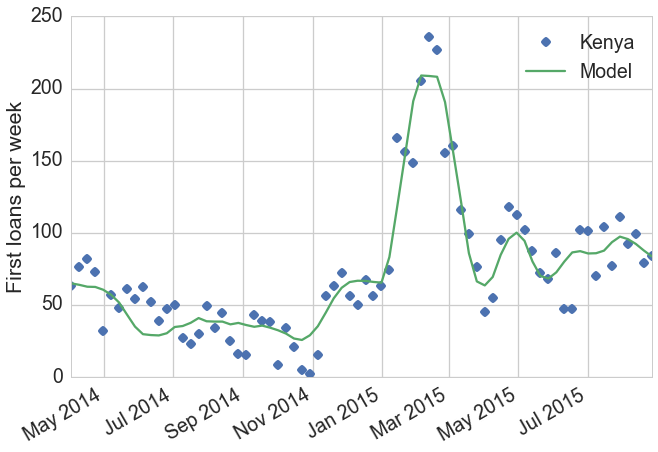

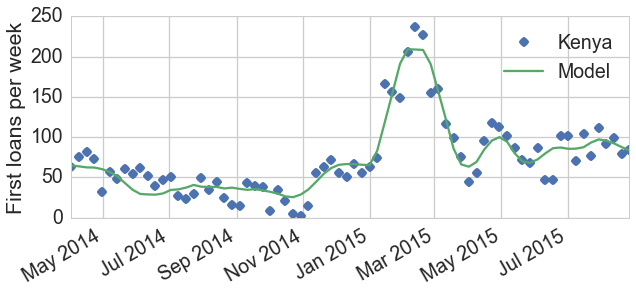

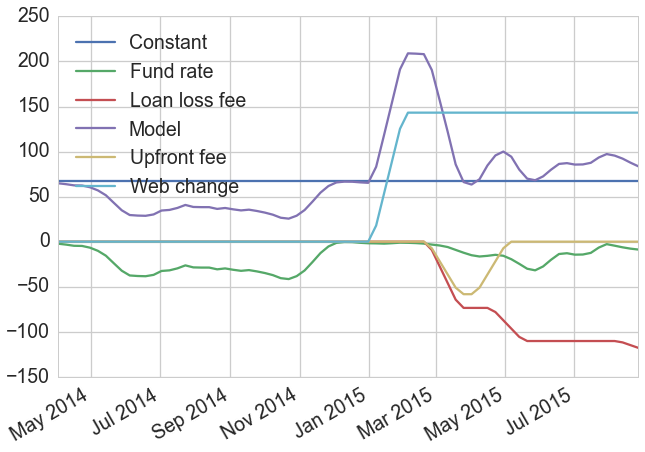

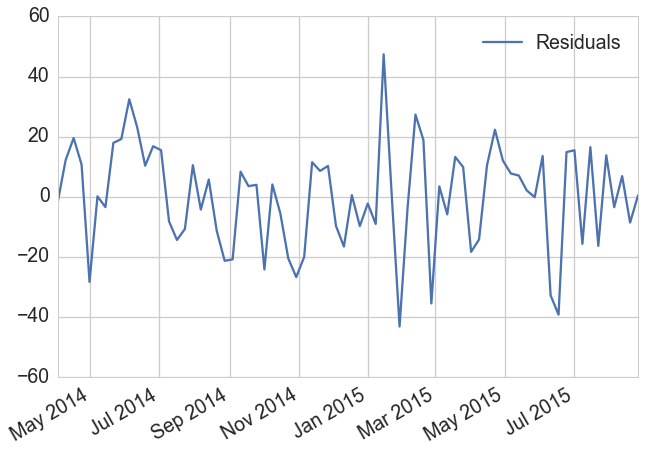

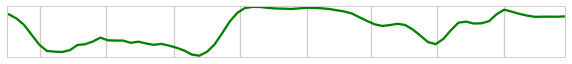

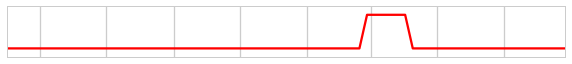

In [54]:
#Fit of Kenya

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

df_kenya_fit_params = pd.DataFrame(index=time_bins_center)

# max lag
lag = round(4.0 / weeks_per_bin)

# fund rate
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = df_fund_rate.Kenya.values.copy() - 1
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
df_kenya_fit_params['Fund rate'] = fund_rate_feature
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]

# loan loss fee
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_kenya.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)

# web change
lag_comp3 = round(2.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 4)

# fund rate effect after web change
fund_rate_after_feature = fund_rate_feature.copy()
fund_rate_after_feature *= web_change

# upfront fee
lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)


invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_new_borrowers_count.Kenya.values[lag:].copy()
label_array = df_first_loans_count.Kenya.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()


start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]
fund_rate_after_feature = fund_rate_after_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['o', '-'])
plt.ylabel('First loans per week')
#plt.xlabel('Date')


stack_fig_width = 10
stack_fig_height = 1
df_fit2 = pd.DataFrame({'Kenya': label_array, 'Model': results.predict()}, columns=['Kenya', 'Model'],index=time_axis)
df_fit2.plot(figsize=(stack_fig_width, 4*stack_fig_height), style=['o', '-'])
plt.ylabel('First loans per week')


#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
#labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee', 'Fund rate after']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

peak_times = np.array([np.datetime64('2015-01-01T00Z', 'ns'), np.datetime64('2015-03-01T00Z', 'ns')])
peak_range = np.searchsorted(time_axis.values, peak_times)
norm_scale = 1 / np.amax(results.predict()[peak_range[0]:peak_range[1]])

kenya_nlr = label_array.copy()
#kenya_scaled = kenya_nlr.copy() * results.params[0]/results.params[2]
kenya_scaled = kenya_nlr.copy() * norm_scale
kenya_fit_scaled = results.predict() * norm_scale

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

kenya_norm_params = results.params / results.params[0]
kenya_norm_bse = results.bse / results.params[0]
print(kenya_norm_params)
print(kenya_norm_bse)

print(kenya_norm_params[2] + 2*np.sqrt(kenya_norm_bse[0]**2 + kenya_norm_bse[2]**2))

stack_fig_width = 10
stack_fig_height = 1
df_plot = df_kenya_fit_params.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
#df_fund_rate_feature = pd.DataFrame({'Fund rate': fund_rate_feature}, index=time_axis)
#df_plot = df_fund_rate_feature.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.yticks([])
df_plot.set_xticklabels([])


#df_upfront_fee_feature = pd.DataFrame({'Upfront fee': upfront_fee_feature}, index=time_axis)
#df_plot = df_upfront_fee_feature.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
df_plot = df_upfront_fee.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['r'])
plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
plt.ylim([-.25,1.25])
plt.yticks([])
df_plot.set_xticklabels([])

#df_plot = df_website_change.plot(figsize=(stack_fig_width, stack_fig_height), yticks=[], grid=True, legend=False, style=['g'])
#plt.xlim([pd.datetime(2014, 4, 1), time_bins_center[-1]])
#plt.ylim([-.25,1.25])
#df_plot.axes.set_xticklabels([]);

m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)

#glm_poisson = sm.GLM(label_array, feature_mat, family=sm.families.Poisson())
#glm_result = glm_poisson.fit()
#print(glm_result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     92.09
Date:                Thu, 01 Oct 2015   Prob (F-statistic):           6.45e-27
Time:                        17:51:32   Log-Likelihood:                -294.10
No. Observations:                  74   AIC:                             598.2
Df Residuals:                      69   BIC:                             609.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         23.8456      3.793      6.287      0.0

,0,1,2,3,4
0,1.000000,0.274322,-0.609628,-0.834012,-0.029332
1,0.274322,1.000000,-0.804580,-0.316966,-0.187909
2,-0.609628,-0.804580,1.000000,0.503147,-0.057282
3,-0.834012,-0.316966,0.503147,1.000000,0.036572
4,-0.029332,-0.187909,-0.057282,0.036572,1.000000


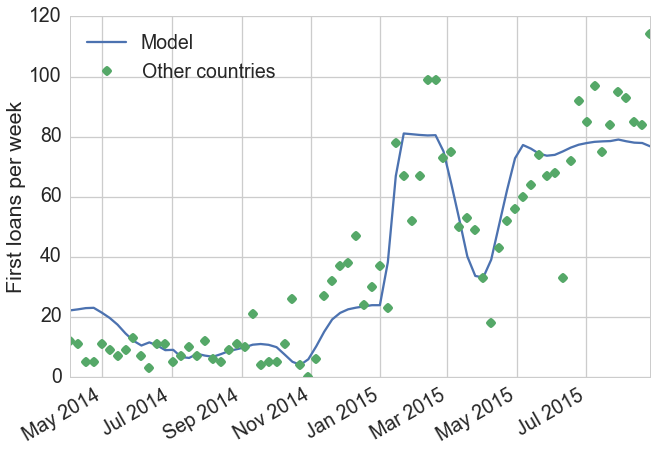

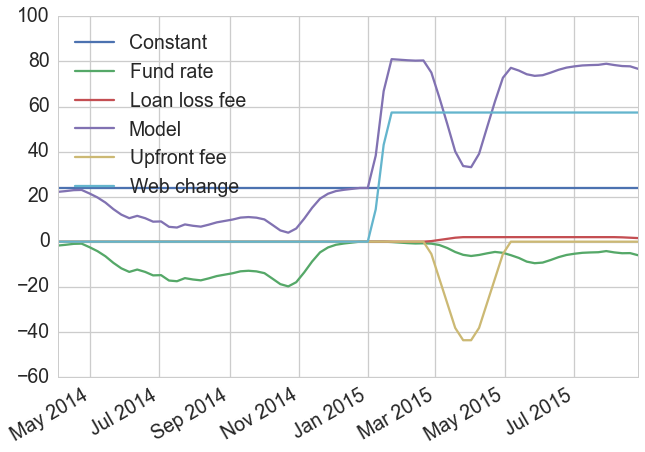

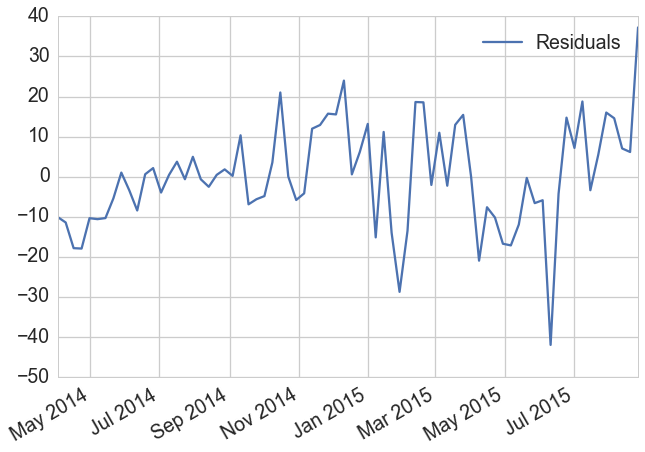

In [55]:
#Fit of other countries

fully_funded_other = df_fully_funded_count.Indonesia.values.copy()
fully_funded_other += df_fully_funded_count.Ghana.values.copy()
fully_funded_other += df_fully_funded_count['Burkina Faso'].values.copy()
all_loans_other = df_all_loans_count.Indonesia.values.copy()
all_loans_other += df_all_loans_count.Ghana.values.copy()
all_loans_other += df_all_loans_count['Burkina Faso'].values.copy()

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

lag = round(4.0 / weeks_per_bin)
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = 1 - fully_funded_other / all_loans_other
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)
lag_comp3 = round(3.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 2)

lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)



invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Indonesia.values[lag:].copy()
label_array += df_first_loans_count.Ghana.values[lag:].copy()
label_array += df_first_loans_count['Burkina Faso'].values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Other countries': label_array, 'Model': results.predict()}, index=time_axis)
df_fit1.plot(style=['-', 'o'])
plt.ylabel('First loans per week')
#plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

peak_times = np.array([np.datetime64('2015-01-01T00Z', 'ns'), np.datetime64('2015-03-01T00Z', 'ns')])
peak_range = np.searchsorted(time_axis.values, peak_times)
norm_scale = 1 / np.amax(results.predict()[peak_range[0]:peak_range[1]])

other_nlr = label_array.copy()
#other_scaled = other_nlr.copy()# * results.params[0]/results.params[2]
other_scaled = other_nlr.copy() * norm_scale
other_fit_scaled = results.predict() * norm_scale

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

other_norm_params = results.params * norm_scale
other_norm_bse = results.bse * norm_scale
print(other_norm_params)
print(other_norm_bse)
print(other_norm_params[2] - 2*np.sqrt(other_norm_bse[0]**2 + other_norm_bse[2]**2))


m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     75.45
Date:                Thu, 01 Oct 2015   Prob (F-statistic):           6.88e-22
Time:                        17:51:35   Log-Likelihood:                -229.91
No. Observations:                  74   AIC:                             467.8
Df Residuals:                      70   BIC:                             477.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.8152      0.846      2.145      0.0

,0,1,2,3
0,1.000000,0.050416,-0.324669,0.007229
1,0.050416,1.000000,-0.878860,-0.085647
2,-0.324669,-0.878860,1.000000,-0.126010
3,0.007229,-0.085647,-0.126010,1.000000


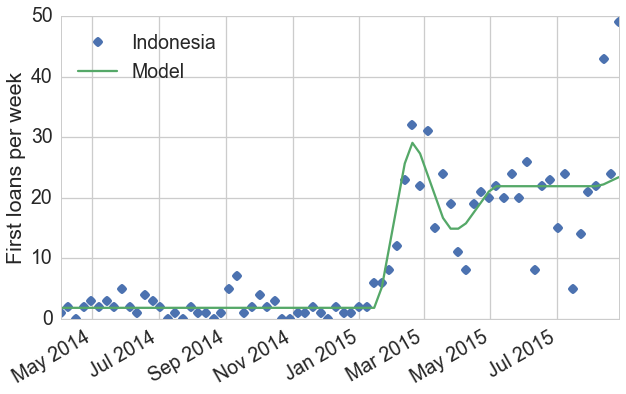

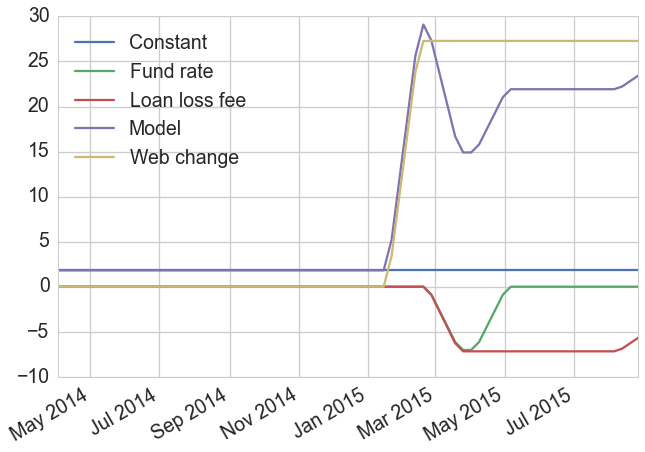

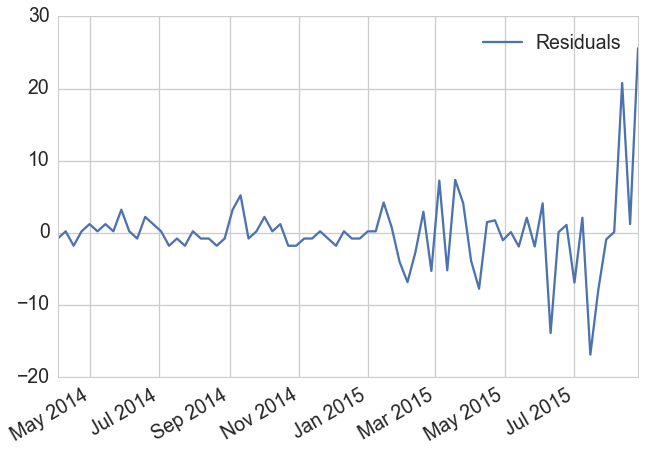

In [56]:
#Fit of Indonesia

fully_funded_indonesia = df_fully_funded_count.Indonesia.values.copy()
all_loans_indonesia = df_all_loans_count.Indonesia.values.copy()

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

# max lag
lag = round(4.0 / weeks_per_bin)

# fund rate
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = 1 - fully_funded_indonesia / all_loans_indonesia
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]

# loan loss fee
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)

# web change
lag_comp3 = round(0.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 4)

# scale fund rate feature by web change
fund_rate_feature *= web_change

# upfront fee
lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)


invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Indonesia.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
#feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: Website change', 'x3: Upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Indonesia': label_array, 'Model': results.predict()}, columns=['Indonesia', 'Model'], index=time_axis)
df_fit1.plot(style=['o', '-'], figsize=(10, 6))
plt.ylabel('First loans per week')
#plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
#labels = ['Constant', 'Loan loss fee', 'Web change', 'Upfront fee']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

peak_times = np.array([np.datetime64('2015-01-01T00Z', 'ns'), np.datetime64('2015-03-01T00Z', 'ns')])
peak_range = np.searchsorted(time_axis.values, peak_times)
norm_scale = 1 / np.amax(results.predict()[peak_range[0]:peak_range[1]])

indonesia_nlr = label_array.copy()
#other_scaled = other_nlr.copy()# * results.params[0]/results.params[2]
indonesia_scaled = indonesia_nlr.copy() * norm_scale
indonesia_fit_scaled = results.predict() * norm_scale

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

indonesia_norm_params = results.params / results.params[0]
indonesia_norm_bse = results.bse / results.params[0]
print(indonesia_norm_params)
print(indonesia_norm_bse)
print(indonesia_norm_params[2] - 2*np.sqrt(indonesia_norm_bse[0]**2 + indonesia_norm_bse[2]**2))


m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     79.56
Date:                Thu, 01 Oct 2015   Prob (F-statistic):           1.66e-22
Time:                        17:51:37   Log-Likelihood:                -275.32
No. Observations:                  74   AIC:                             558.6
Df Residuals:                      70   BIC:                             567.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          5.2154      1.600      3.260      0.0

,0,1,2,3
0,1.000000,0.039554,-0.381923,0.004761
1,0.039554,1.000000,-0.821652,-0.154096
2,-0.381923,-0.821652,1.000000,-0.098910
3,0.004761,-0.154096,-0.098910,1.000000


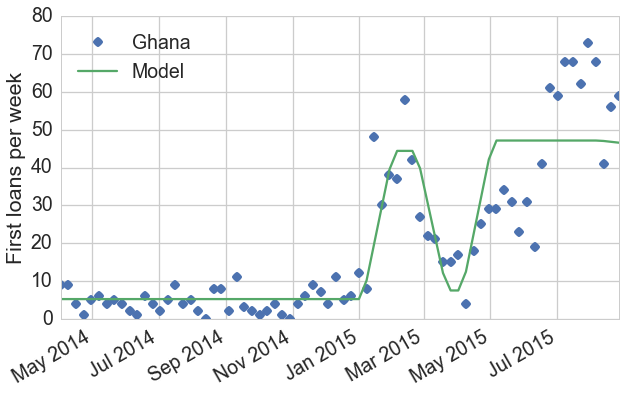

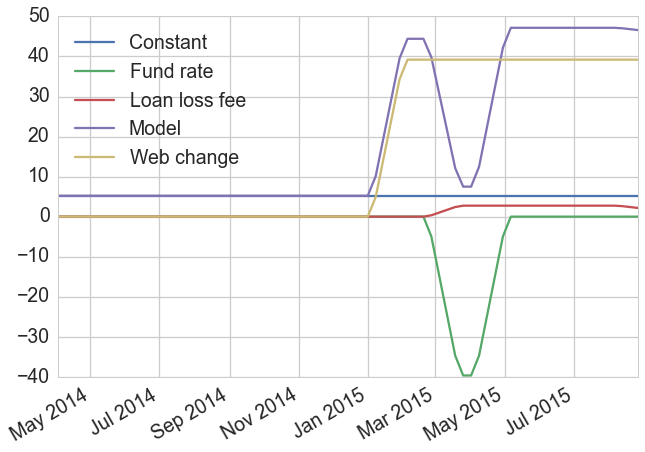

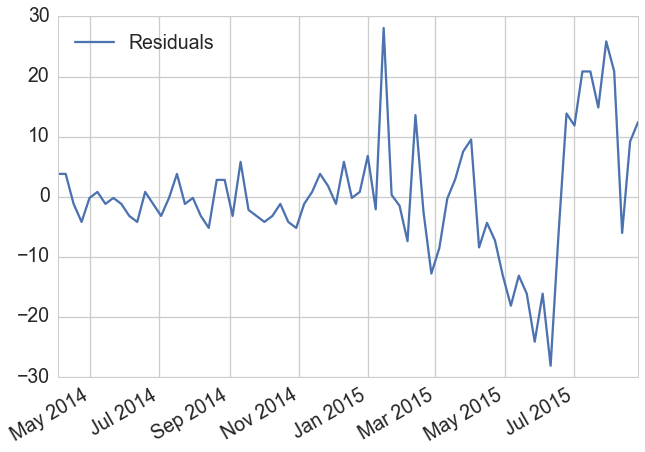

In [57]:
#Fit of Ghana

fully_funded_ghana = df_fully_funded_count.Ghana.values.copy()
all_loans_ghana = df_all_loans_count.Ghana.values.copy()

# Fit matrix, n_samples x n_features
#disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
#fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values

# max lag
lag = round(4.0 / weeks_per_bin)

# fund rate
lag_comp = round(0.0 / weeks_per_bin)
lag_fund = lag - lag_comp
fund_rate_feature = 1 - fully_funded_ghana / all_loans_ghana
# Subtract 2 from the lag to compensate for the two weeks between the creation of the loan and the end of the loan
fund_rate_feature = rect_window_filter(fund_rate_feature, 2*(lag_fund - 2))
fund_rate_feature = fund_rate_feature[lag_comp:-lag+lag_comp]

#loan loss fee
lag_comp2 = round(2.0 / weeks_per_bin)
lag_fee = lag - lag_comp2
lag_end = -lag+lag_comp2
if lag_end:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:-lag+lag_comp2].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:-lag+lag_comp2].copy()
else:
    loan_loss_fee = df_loan_loss_fee_other.fee_level.values[lag_comp2:].copy()
    max_loan = df_max_first_loan.max_loan.values[lag_comp2:].copy()
loan_loss_fee /= max_loan
loan_loss_fee = rect_window_filter(loan_loss_fee, lag_fee*2)
#loan_loss_fee = rect_window_filter(loan_loss_fee, 2)

# website
lag_comp3 = round(2.0 / weeks_per_bin)
lag_end3 = -lag+lag_comp3
if lag_end3:
    web_change = df_website_change.web_change.values[lag_comp3:-lag+lag_comp3].copy()
else:
    web_change = df_website_change.web_change.values[lag_comp3:].copy()
web_change = rect_window_filter(web_change, 4)

fund_rate_feature *= web_change

# upfront fee
lag_comp4 = round(2.0 / weeks_per_bin)
lag_upfront = lag - lag_comp4
upfront_fee_feature = df_upfront_fee.upfront_fee.values[lag_comp4:-lag+lag_comp4].copy()
#upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2)
upfront_fee_feature = rect_window_filter(upfront_fee_feature, 2*lag_upfront)



invite_feature = df_total_borrowers.Kenya.values[:-lag].copy() * df_max_invites.max_invites.values[:-lag].copy()
max_loan_feature = df_max_first_loan.max_loan.values[:-lag].copy()

label_array = df_first_loans_count.Ghana.values[lag:].copy()
time_axis = time_bins_center[lag:].copy()

#fund_rate_feature = fund_rate_feature**4 # Sharpen funding rate feature, assumes borrowers are very sensitive

start_date = pd.datetime(2014,4,1)
for start_index in range(len(time_axis)):
    if time_axis[start_index] >= start_date:
        break
#start_index = 0
invite_feature = invite_feature[start_index:]
fund_rate_feature = fund_rate_feature[start_index:]
max_loan_feature = max_loan_feature[start_index:]
loan_loss_fee = loan_loss_fee[start_index:]
web_change = web_change[start_index:]
upfront_fee_feature = upfront_fee_feature[start_index:]

label_array = label_array[start_index:]
time_axis = time_axis[start_index:]

const_array = np.empty(len(label_array))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, loan_loss_fee, web_change, fund_rate_feature, upfront_fee_feature]))
#feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Loan loss fee', 'x2: website change', 'x3: fund rate', 'x4: upfront fee']
#labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

#plt.scatter(time_axis, label_array)
#plt.plot(time_axis, results.predict())

df_fit1 = pd.DataFrame({'Ghana': label_array, 'Model': results.predict()}, columns=['Ghana', 'Model'], index=time_axis)
df_fit1.plot(style=['o', '-'], figsize=(10, 6))
plt.ylabel('First loans per week')
#plt.xlabel('Date')

#labels = ['const', 'Time to dispersal','Time to fund','Max invites * total borrowers','Fraction funded','Fraction applicants accepted','Maximum loan limit']
labels = ['Constant', 'Loan loss fee', 'Web change', 'Fund rate', 'Upfront fee']
df_dict = {'Model': results.predict()}
for index in range(len(results.params)):
    df_dict[labels[index]] = feature_mat[:,index]*results.params[index]
df_fit = pd.DataFrame(df_dict, index=time_axis)
df_fit.plot()

peak_times = np.array([np.datetime64('2015-01-01T00Z', 'ns'), np.datetime64('2015-03-01T00Z', 'ns')])
peak_range = np.searchsorted(time_axis.values, peak_times)
norm_scale = 1 / np.amax(results.predict()[peak_range[0]:peak_range[1]])

ghana_nlr = label_array.copy()
#other_scaled = other_nlr.copy()# * results.params[0]/results.params[2]
ghana_scaled = ghana_nlr.copy() * norm_scale
ghana_fit_scaled = results.predict() * norm_scale

pd.DataFrame({'Residuals': results.resid}, index=time_axis).plot()

ghana_norm_params = results.params / results.params[0]
ghana_norm_bse = results.bse / results.params[0]
print(ghana_norm_params)
print(ghana_norm_bse)
print(ghana_norm_params[2] - 2*np.sqrt(ghana_norm_bse[0]**2 + ghana_norm_bse[2]**2))


m_corr = results.cov_params()
v_sdev = np.sqrt(np.diag(m_corr))
m_corr /= np.outer(v_sdev, v_sdev)
pd.DataFrame(m_corr)


In [51]:
'''
df_scaled = pd.DataFrame({'Kenya':kenya_scaled, 'Other':other_scaled}, index=time_axis)
df_scaled.plot()
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['-','--','-','--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['b-','b--','r-','r--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')

df_scaled = pd.DataFrame({'Kenya Data': kenya_scaled, 'Kenya Model': kenya_fit_scaled, 'Other Data': other_scaled, 'Other Model': other_fit_scaled}, index=time_axis)
fp = df_scaled.plot(style=['bo','b--','r^','r--'])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')
'''
time_axis = lag_model_kenya.time_axis
df_scaled = pd.DataFrame({'Kenya model': kenya_fit_scaled,
                          'Ghana model': ghana_fit_scaled,
                          'Indonesia model': indonesia_fit_scaled},
                         columns=['Kenya model', 'Ghana model', 'Indonesia model'], index=time_axis)
fp = df_scaled.plot(style=['-', '--'], figsize=(10, 6))
plt.ylim([0,1.2])
#plt.setp(fp, linestyle='--')
#plt.Line2D.set_linestyle('--')
plt.ylabel('Normalized first loan rate')
